In [4]:
# Install external libraries (only needs to be done once in Colab)
!pip install imbalanced-learn xgboost


In [5]:
# Upload your local CSV file
from google.colab import files
uploaded = files.upload()  # Upload your file here (e.g., cs-training.csv)

# Load the CSV file (change filename if necessary)
import pandas as pd

data = pd.read_csv('cs-training.csv', index_col=0)  # Adjust filename if needed
data.head()


Saving credit_risk_dataset.csv to credit_risk_dataset.csv


,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
person_age,,,,,,,,,,,
22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [9]:
print(data_encoded.columns)


Index(['person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate',
       'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B',
       'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F',
       'loan_grade_G', 'cb_person_default_on_file_Y'],
      dtype='object')


In [6]:
# Identify categorical columns (those with text values)
categorical_cols = data.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_cols)

# Convert categorical columns to numeric using one-hot encoding
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)


Categorical Columns: Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')


In [7]:
# Fill missing values with median of each column
data_encoded = data_encoded.fillna(data_encoded.median())


In [10]:
# Define features (X) and target (y)
X = data_encoded.drop('loan_status', axis=1)
y = data_encoded['loan_status']


In [11]:
from sklearn.preprocessing import StandardScaler

# Scale the feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [12]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to handle class imbalance
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)


In [13]:
from sklearn.model_selection import train_test_split

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)


In [14]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score


In [15]:
# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict
rf_preds = rf_model.predict(X_test)


In [16]:
# Train Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predict
gb_preds = gb_model.predict(X_test)


In [17]:
# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
xgb_preds = xgb_model.predict(X_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:09:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [18]:
def evaluate_model(name, y_test, y_pred):
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


In [19]:
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("Gradient Boosting", y_test, gb_preds)
evaluate_model("XGBoost", y_test, xgb_preds)



=== Random Forest ===
Accuracy: 0.9408243375858685
ROC AUC Score: 0.940830595171837
Confusion Matrix:
 [[4955  139]
 [ 464 4632]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      5094
           1       0.97      0.91      0.94      5096

    accuracy                           0.94     10190
   macro avg       0.94      0.94      0.94     10190
weighted avg       0.94      0.94      0.94     10190


=== Gradient Boosting ===
Accuracy: 0.8914622178606477
ROC AUC Score: 0.8914709197079211
Confusion Matrix:
 [[4767  327]
 [ 779 4317]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90      5094
           1       0.93      0.85      0.89      5096

    accuracy                           0.89     10190
   macro avg       0.89      0.89      0.89     10190
weighted avg       0.89      0.89      0.89     10190


=== XGBoost ===
Accuracy: 0.95

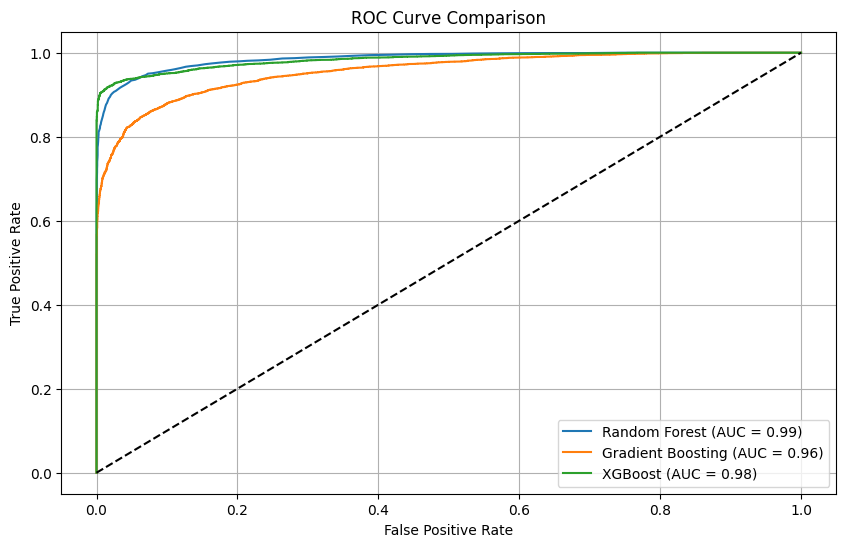

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def plot_roc_curve(model, X_test, y_test, label):
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_score(y_test, y_probs):.2f})')

plt.figure(figsize=(10, 6))
plot_roc_curve(rf_model, X_test, y_test, "Random Forest")
plot_roc_curve(gb_model, X_test, y_test, "Gradient Boosting")
plot_roc_curve(xgb_model, X_test, y_test, "XGBoost")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


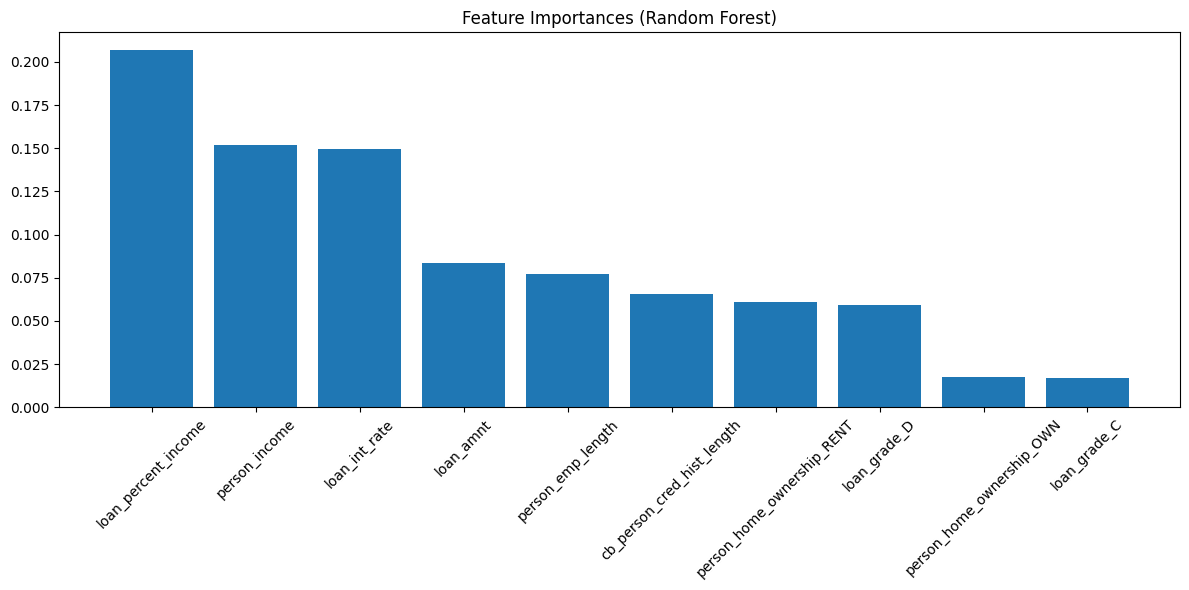

In [21]:
import numpy as np

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45)
plt.tight_layout()
plt.show()


In [22]:
import joblib

# Save model to file
joblib.dump(xgb_model, "credit_risk_xgb_model.pkl")
print("Model saved as credit_risk_xgb_model.pkl")


Model saved as credit_risk_xgb_model.pkl


In [23]:
# Load model
loaded_model = joblib.load("credit_risk_xgb_model.pkl")

# Make predictions
new_predictions = loaded_model.predict(X_test)


In [24]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


In [25]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}


In [26]:
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


In [27]:
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:21:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1]},
             scoring='roc_auc', verbose=1)

In [28]:
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)


Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best ROC AUC Score: 0.9844439608393433


In [29]:
# Predict with best estimator
best_xgb = grid_search.best_estimator_
xgb_preds_tuned = best_xgb.predict(X_test)

# Use the previous evaluation function
evaluate_model("Tuned XGBoost", y_test, xgb_preds_tuned)



=== Tuned XGBoost ===
Accuracy: 0.9544651619234543
ROC AUC Score: 0.954471516340522
Confusion Matrix:
 [[5027   67]
 [ 397 4699]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.99      0.92      0.95      5096

    accuracy                           0.95     10190
   macro avg       0.96      0.95      0.95     10190
weighted avg       0.96      0.95      0.95     10190

